import json
import pandas as pd
import matplotlib.pyplot as plt

# 파일 경로
json_input = 'result_DeepSeek-R1-Distill-Llama-70B-20250625-003249_vllm.json'
csv_input  = 'resource_usage_2025-06-25_00:30:38.csv'
json_output = 'result_DeepSeek-R1-Distill-Llama-70B-20250625-003249_vllm_agg.json'

# JSON 로드
with open(json_input, 'r') as f:
    experiments = json.load(f)

# CSV 로드
df_res = pd.read_csv(csv_input)

# 컬럼 검사
timestamp_col = next(col for col in df_res.columns if 'time' in col.lower())
gpu_col = next(col for col in df_res.columns if 'gpu0_util' in col.lower())

# timestamp 문자열에서 대괄호 제거 후 datetime 변환
df_res[timestamp_col] = df_res[timestamp_col].str.strip('[]')
df_res[timestamp_col] = pd.to_datetime(df_res[timestamp_col], format='%Y-%m-%d %H:%M:%S')

# 실험별 리소스 데이터 병합
merged = []
for exp in experiments:
    # 실험 시작시간 파싱 (date 필드 가정)
    start = pd.to_datetime(exp['date'], format='%Y%m%d-%H%M%S', errors='coerce')
    dur = float(exp.get('duration', 0))
    end = start + pd.to_timedelta(dur, unit='s')
    
    slice_df = df_res[(df_res[timestamp_col] >= start) & (df_res[timestamp_col] <= end)]
    exp['resource_usage'] = slice_df.to_dict(orient='records')
    merged.append(exp)

# 병합된 JSON 저장
with open(json_output, 'w') as f:
    json.dump(merged, f, indent=2, default=str)
print(f"Merged JSON saved to {json_output}")

with open(json_output) as f:
    merged = json.load(f)
res = pd.DataFrame(merged[20]['resource_usage'])

time_col = next(c for c in res.columns if 'time' in c.lower())
res[time_col] = pd.to_datetime(res[time_col])

# 4) GPU Util 컬럼 자동 추출 (GPU0_Util(%) ~ GPU7_Util(%))
gpu_cols = [c for c in res.columns if c.startswith('GPU') and 'Util' in c]

# 5) GPU0–GPU7 사용률 플롯
plt.figure(figsize=(12, 6))
for col in gpu_cols:
    plt.plot(res[time_col], res[col], marker='o', label=col)

plt.title('GPU0–GPU7 Utilization Over Time')
plt.xlabel('Time')
plt.ylabel('Utilization (%)')
plt.legend(ncol=4, bbox_to_anchor=(0, 1.15), loc='lower left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

여기서 부터 시작

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import os

insert_agg = (lambda suffix: lambda fn: f"{fn.rsplit('.',1)[0]}{suffix}.{fn.rsplit('.',1)[1]}")('_agg')

In [51]:
# 파일 경로
json_input  = 'result_DeepSeek-R1-Distill-Llama-70B-20250625-003249_vllm.json'
csv_input   = 'resource_usage_2025-06-25_00:30:38.csv'

In [2]:
# 파일 경로
json_input  = 'DeepSeek-R1-Distill-Llama-70B-20250625-060421-vllm.json'
csv_input   = 'resource_usage_2025-06-25_060158.csv'

In [2]:
# 파일 경로
json_input  = 'result_vllm_sglang_w_n_wo_dynamo_20250627_2128.json'
csv_input   = 'resource_usage_2025-06-27-21-28.csv'

In [3]:
json_output = insert_agg(json_input)

# 1. JSON 로드
with open(json_input, 'r') as f:
    experiments = json.load(f)

# 2. CSV 로드 & 전처리
df_res = pd.read_csv(csv_input)
# Time 컬럼
time_col = next(c for c in df_res.columns if 'time' in c.lower())
df_res[time_col] = pd.to_datetime(df_res[time_col].str.strip('[]'), format='%Y-%m-%d %H:%M:%S')
# GPU Util 컬럼들
gpu_cols = [c for c in df_res.columns if c.startswith('GPU') and 'Util' in c]

merged = []
for exp in experiments:
    # (a) 실험 시작 시각
    start = pd.to_datetime(exp['date'], format='%Y%m%d-%H%M%S')
    df_after_start = df_res[df_res[time_col] >= start].copy()
    
    # (b) 첫 all-zero 구간 끝_idx
    zero_all = (df_after_start[gpu_cols] == 0).all(axis=1)
    first_zero_idx = zero_all.idxmax()# first True
    df_after_zero = df_after_start.loc[first_zero_idx+1:].copy()  # 첫 all-zero 뒤부터
    
    # (c) 그 뒤 첫 non-zero 시점 찾기
    non_zero_mask = (df_after_zero[gpu_cols] != 0).any(axis=1)
    first_nonzero_idx = non_zero_mask.idxmax()
    df_after_nonzero = df_after_zero.loc[first_nonzero_idx:].copy()
   
    # (d) 다음 all-zero 구간 (종료)까지 필터
    zero2 = (df_after_nonzero[gpu_cols] == 0).all(axis=1)
    if zero2.any():
        end2_idx = zero2.idxmax()
        df_segment = df_after_nonzero.loc[:end2_idx].copy()
    else:
        df_segment = df_after_nonzero
        
    gpu_stats = {}
    for gpu in gpu_cols:
        data = df_segment[gpu]
        # 0을 제외한 값만 선택
        non_zero = data[data > 0]
        # non_zero가 비어 있으면 0.0, 아니면 최솟값
        min_val = float(non_zero.min()) if not non_zero.empty else 0.0
        max_val = float(data.max())
        mid_val = float(data.median())
        avg_val = float(data.mean())

        gpu_stats[gpu] = {
            'min': min_val,
            'max': max_val,
            'mid': mid_val,
            'avg': avg_val,
        }
    exp['gpu_stats'] = gpu_stats
    
    # 리소스 시계열 저장
    exp['resource_usage'] = df_segment.to_dict(orient='records')
    merged.append(exp)

# 3. 새 JSON 저장
with open(json_output, 'w') as f:
    json.dump(merged, f, indent=2, default=str)


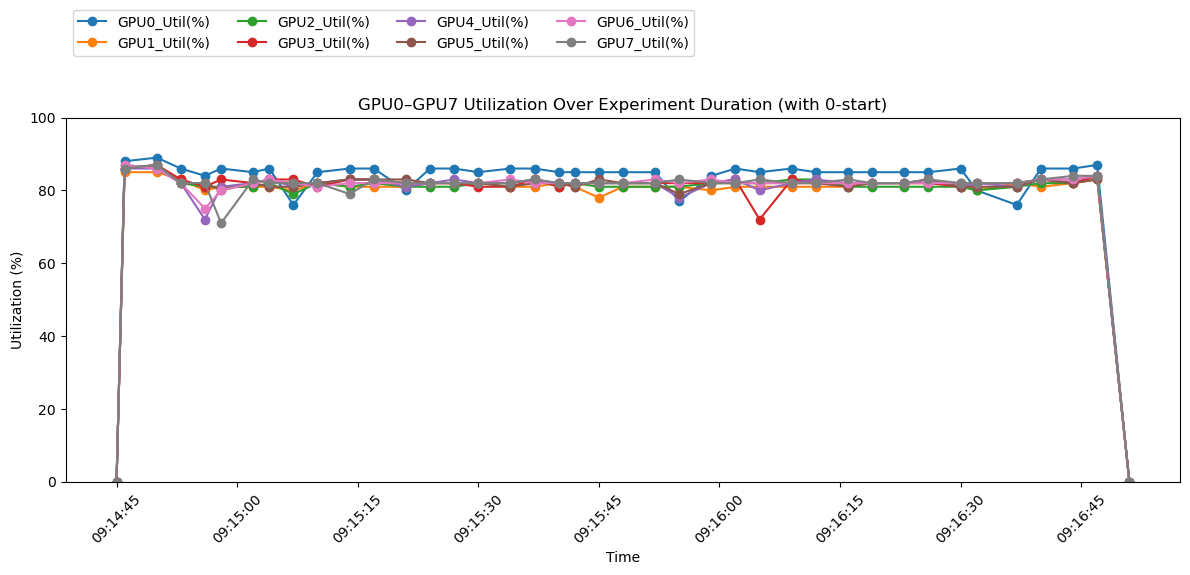

In [4]:
# 2) 첫 번째 실험 resource_usage → DataFrame
res = pd.DataFrame(experiments[0]['resource_usage'])

# 3) Time 컬럼 파싱
time_col = next(c for c in res.columns if 'time' in c.lower())
res[time_col] = pd.to_datetime(res[time_col])

# 4) GPU Util 컬럼 추출
gpu_cols = [c for c in res.columns if c.startswith('GPU') and 'Util' in c]

# 5) “모든 GPU 0” 행을 데이터 앞에 추가
#    시작 시각 바로 이전으로 설정해주세요.
start_time = res[time_col].min()
zero_row = {time_col: start_time - pd.Timedelta(seconds=1)}
for c in gpu_cols:
    zero_row[c] = 0
# DataFrame 위에 붙이기
res = pd.concat([pd.DataFrame([zero_row]), res], ignore_index=True)

# 6) 플롯
plt.figure(figsize=(12, 6))
for col in gpu_cols:
    plt.plot(res[time_col], res[col], marker='o', label=col)

plt.title('GPU0–GPU7 Utilization Over Experiment Duration (with 0-start)')
plt.xlabel('Time')
plt.ylabel('Utilization (%)')
plt.ylim(0, 100)  # 0에서 100%로 고정
plt.legend(ncol=4, bbox_to_anchor=(0, 1.15), loc='lower left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
res

,Time,GPU0_Util(%),GPU1_Util(%),GPU2_Util(%),GPU3_Util(%),GPU4_Util(%),GPU5_Util(%),GPU6_Util(%),GPU7_Util(%),CPU(%),RAM(%),GPU0_Mem(MB),GPU1_Mem(MB),GPU2_Mem(MB),GPU3_Mem(MB),GPU4_Mem(MB),GPU5_Mem(MB),GPU6_Mem(MB),GPU7_Mem(MB)
0,2025-06-27 09:14:45,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-06-27 09:14:46,88,85,87,86,86,86,87,86,4.8,11.5,74426.0,80596.0,80596.0,80596.0,80596.0,80596.0,80596.0,80116.0
2,2025-06-27 09:14:50,89,85,86,87,86,87,86,87,4.4,11.5,74426.0,80596.0,80596.0,80596.0,80596.0,80596.0,80596.0,80116.0
3,2025-06-27 09:14:53,86,83,82,83,82,82,82,82,4.6,11.5,74426.0,80596.0,80596.0,80596.0,80596.0,80596.0,80596.0,80116.0
4,2025-06-27 09:14:56,84,80,81,81,72,82,75,82,4.6,11.5,74426.0,80596.0,80596.0,80596.0,80596.0,80596.0,80596.0,80116.0
5,2025-06-27 09:14:58,86,81,81,83,81,80,80,71,5.0,11.5,74426.0,80596.0,80596.0,80596.0,80596.0,80596.0,80596.0,80116.0
6,2025-06-27 09:15:02,85,81,81,82,82,82,82,83,4.8,11.5,74426.0,80596.0,80596.0,80596.0,80596.0,80596.0,80596.0,80116.0
7,2025-06-27 09:15:04,86,81,82,83,83,81,83,82,4.5,11.5,74426.0,80596.0,80596.0,80596.0,80596.0,80596.0,80596.0,80116.0
8,2025-06-27 09:15:07,76,80,79,83,81,81,82,82,4.8,11.5,74426.0,80596.0,80596.0,80596.0,80596.0,80596.0,80596.0,80116.0
9,2025-06-27 09:15:10,85,82,82,81,82,82,81,82,21.7,11.5,74426.0,80596.0,80596.0,80596.0,80596.0,80596.0,80596.0,80116.0


Saved aggregated JSON with duration slicing to result_DeepSeek-R1-Distill-Llama-70B-20250625-003249_vllm_agg_duration.json


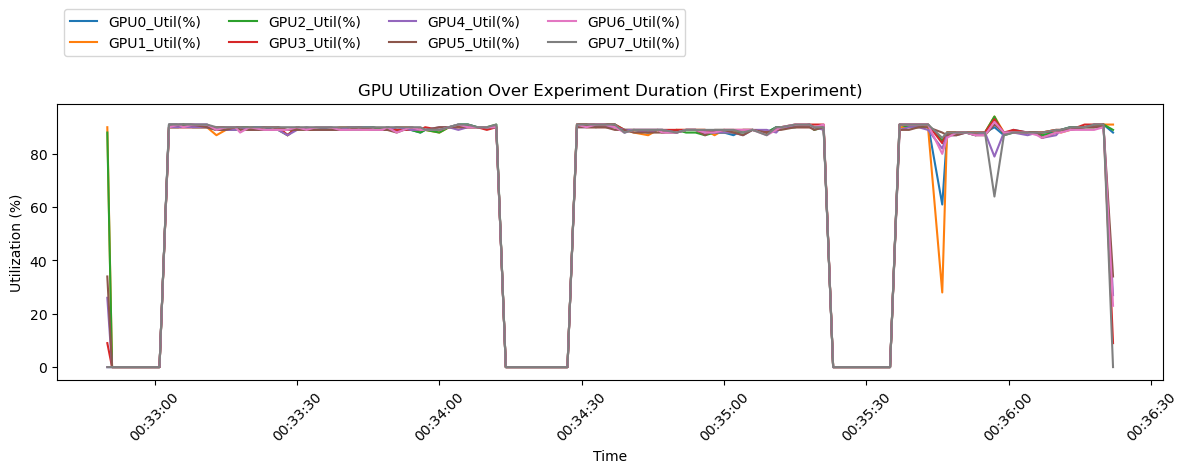

In [27]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# 파일 경로
json_input  = 'result_DeepSeek-R1-Distill-Llama-70B-20250625-003249_vllm.json'
csv_input   = 'resource_usage_2025-06-25_00:30:38.csv'
json_output = 'result_DeepSeek-R1-Distill-Llama-70B-20250625-003249_vllm_agg_duration.json'

# 1. JSON 로드
with open(json_input, 'r') as f:
    experiments = json.load(f)

# 2. CSV 로드 및 전처리
df_res = pd.read_csv(csv_input)
time_col = next(c for c in df_res.columns if 'time' in c.lower())
df_res[time_col] = pd.to_datetime(df_res[time_col].str.strip('[]'), format='%Y-%m-%d %H:%M:%S')
gpu_cols = [c for c in df_res.columns if c.startswith('GPU') and 'Util' in c]

merged = []
for exp in experiments:
    # (a) 실험 시작 및 종료 시각 계산
    start = pd.to_datetime(exp['date'], format='%Y%m%d-%H%M%S')
    dur = float(exp.get('duration', 0)) * 2
    end = start + pd.Timedelta(seconds=dur)
    
    # (b) 해당 구간만 슬라이스
    df_segment = df_res[(df_res[time_col] >= start) & (df_res[time_col] <= end)].copy()
    
    # (c) resource_usage 필드에 저장
    exp['resource_usage'] = df_segment.to_dict(orient='records')
    merged.append(exp)

# 3. JSON 저장
with open(json_output, 'w') as f:
    json.dump(merged, f, indent=2, default=str)
print(f"Saved aggregated JSON with duration slicing to {json_output}")

# 4. 첫 실험 GPU 활용도 플롯
res0 = pd.DataFrame(merged[0]['resource_usage'])
res0[time_col] = pd.to_datetime(res0[time_col])

plt.figure(figsize=(12, 5))
for c in gpu_cols:
    plt.plot(res0[time_col], res0[c], label=c)
plt.title('GPU Utilization Over Experiment Duration (First Experiment)')
plt.xlabel('Time')
plt.ylabel('Utilization (%)')
plt.legend(ncol=4, bbox_to_anchor=(0, 1.15), loc='lower left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [22]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Paths
json_path = 'result_DeepSeek-R1-Distill-Llama-70B-20250625-003249_vllm.json'
csv_path = 'resource_usage_2025-06-25_00:30:38.csv'

# Load JSON
with open(json_path) as f:
    experiments = json.load(f)

# Load CSV resource monitor
# Assume CSV has a timestamp column named 'timestamp' in ISO or similar format and 'gpu_util' column
df_res = pd.read_csv(csv_path)
# Parse timestamps
df_res['timestamp'] = pd.to_datetime(df_res['timestamp'])

# Prepare merged list
merged = []

for exp in experiments:
    # Parse experiment start time
    exp_time = pd.to_datetime(exp['date'], format='%Y%m%d-%H%M%S')
    duration = exp.get('duration', 0)
    # Filter resource data during experiment
    df_slice = df_res[(df_res['timestamp'] >= exp_time) &
                      (df_res['timestamp'] <= exp_time + pd.to_timedelta(duration, unit='s'))]
    # Convert slice to dict records
    exp['resource_usage'] = df_slice.to_dict(orient='records')
    merged.append(exp)

# Save merged JSON
merged_path = 'merged_result_DeepSeek-R1-Distill-Llama-70B-20250625-003249_vllm.json'
with open(merged_path, 'w') as f:
    json.dump(merged, f, indent=2, default=str)

# Plot GPU utilization for first experiment
first_usage = merged[0]['resource_usage']
df_first = pd.DataFrame(first_usage)
plt.figure(figsize=(10, 4))
plt.plot(pd.to_datetime(df_first['timestamp']), df_first['gpu_util'], marker='o')
plt.title('GPU Utilization Over Time (First Experiment)')
plt.xlabel('Time')
plt.ylabel('GPU Utilization (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"[Merged JSON saved to {merged_path}]")


KeyError: 'timestamp'

In [ ]:
merged